In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from scipy.ndimage import gaussian_filter1d
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cml=custom_cmap


# prepare colors for plot
colors = ['#dadaeb','#6a51a3']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
pl = sns.color_palette("dana", n_colors=65)

In [4]:
## update data
def filter_df(df):
    max=39
    thresh=8
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[data.index.get_level_values('age').isin(ages_greater)]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [6]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
m_data = data[sorted(data.columns)].copy()

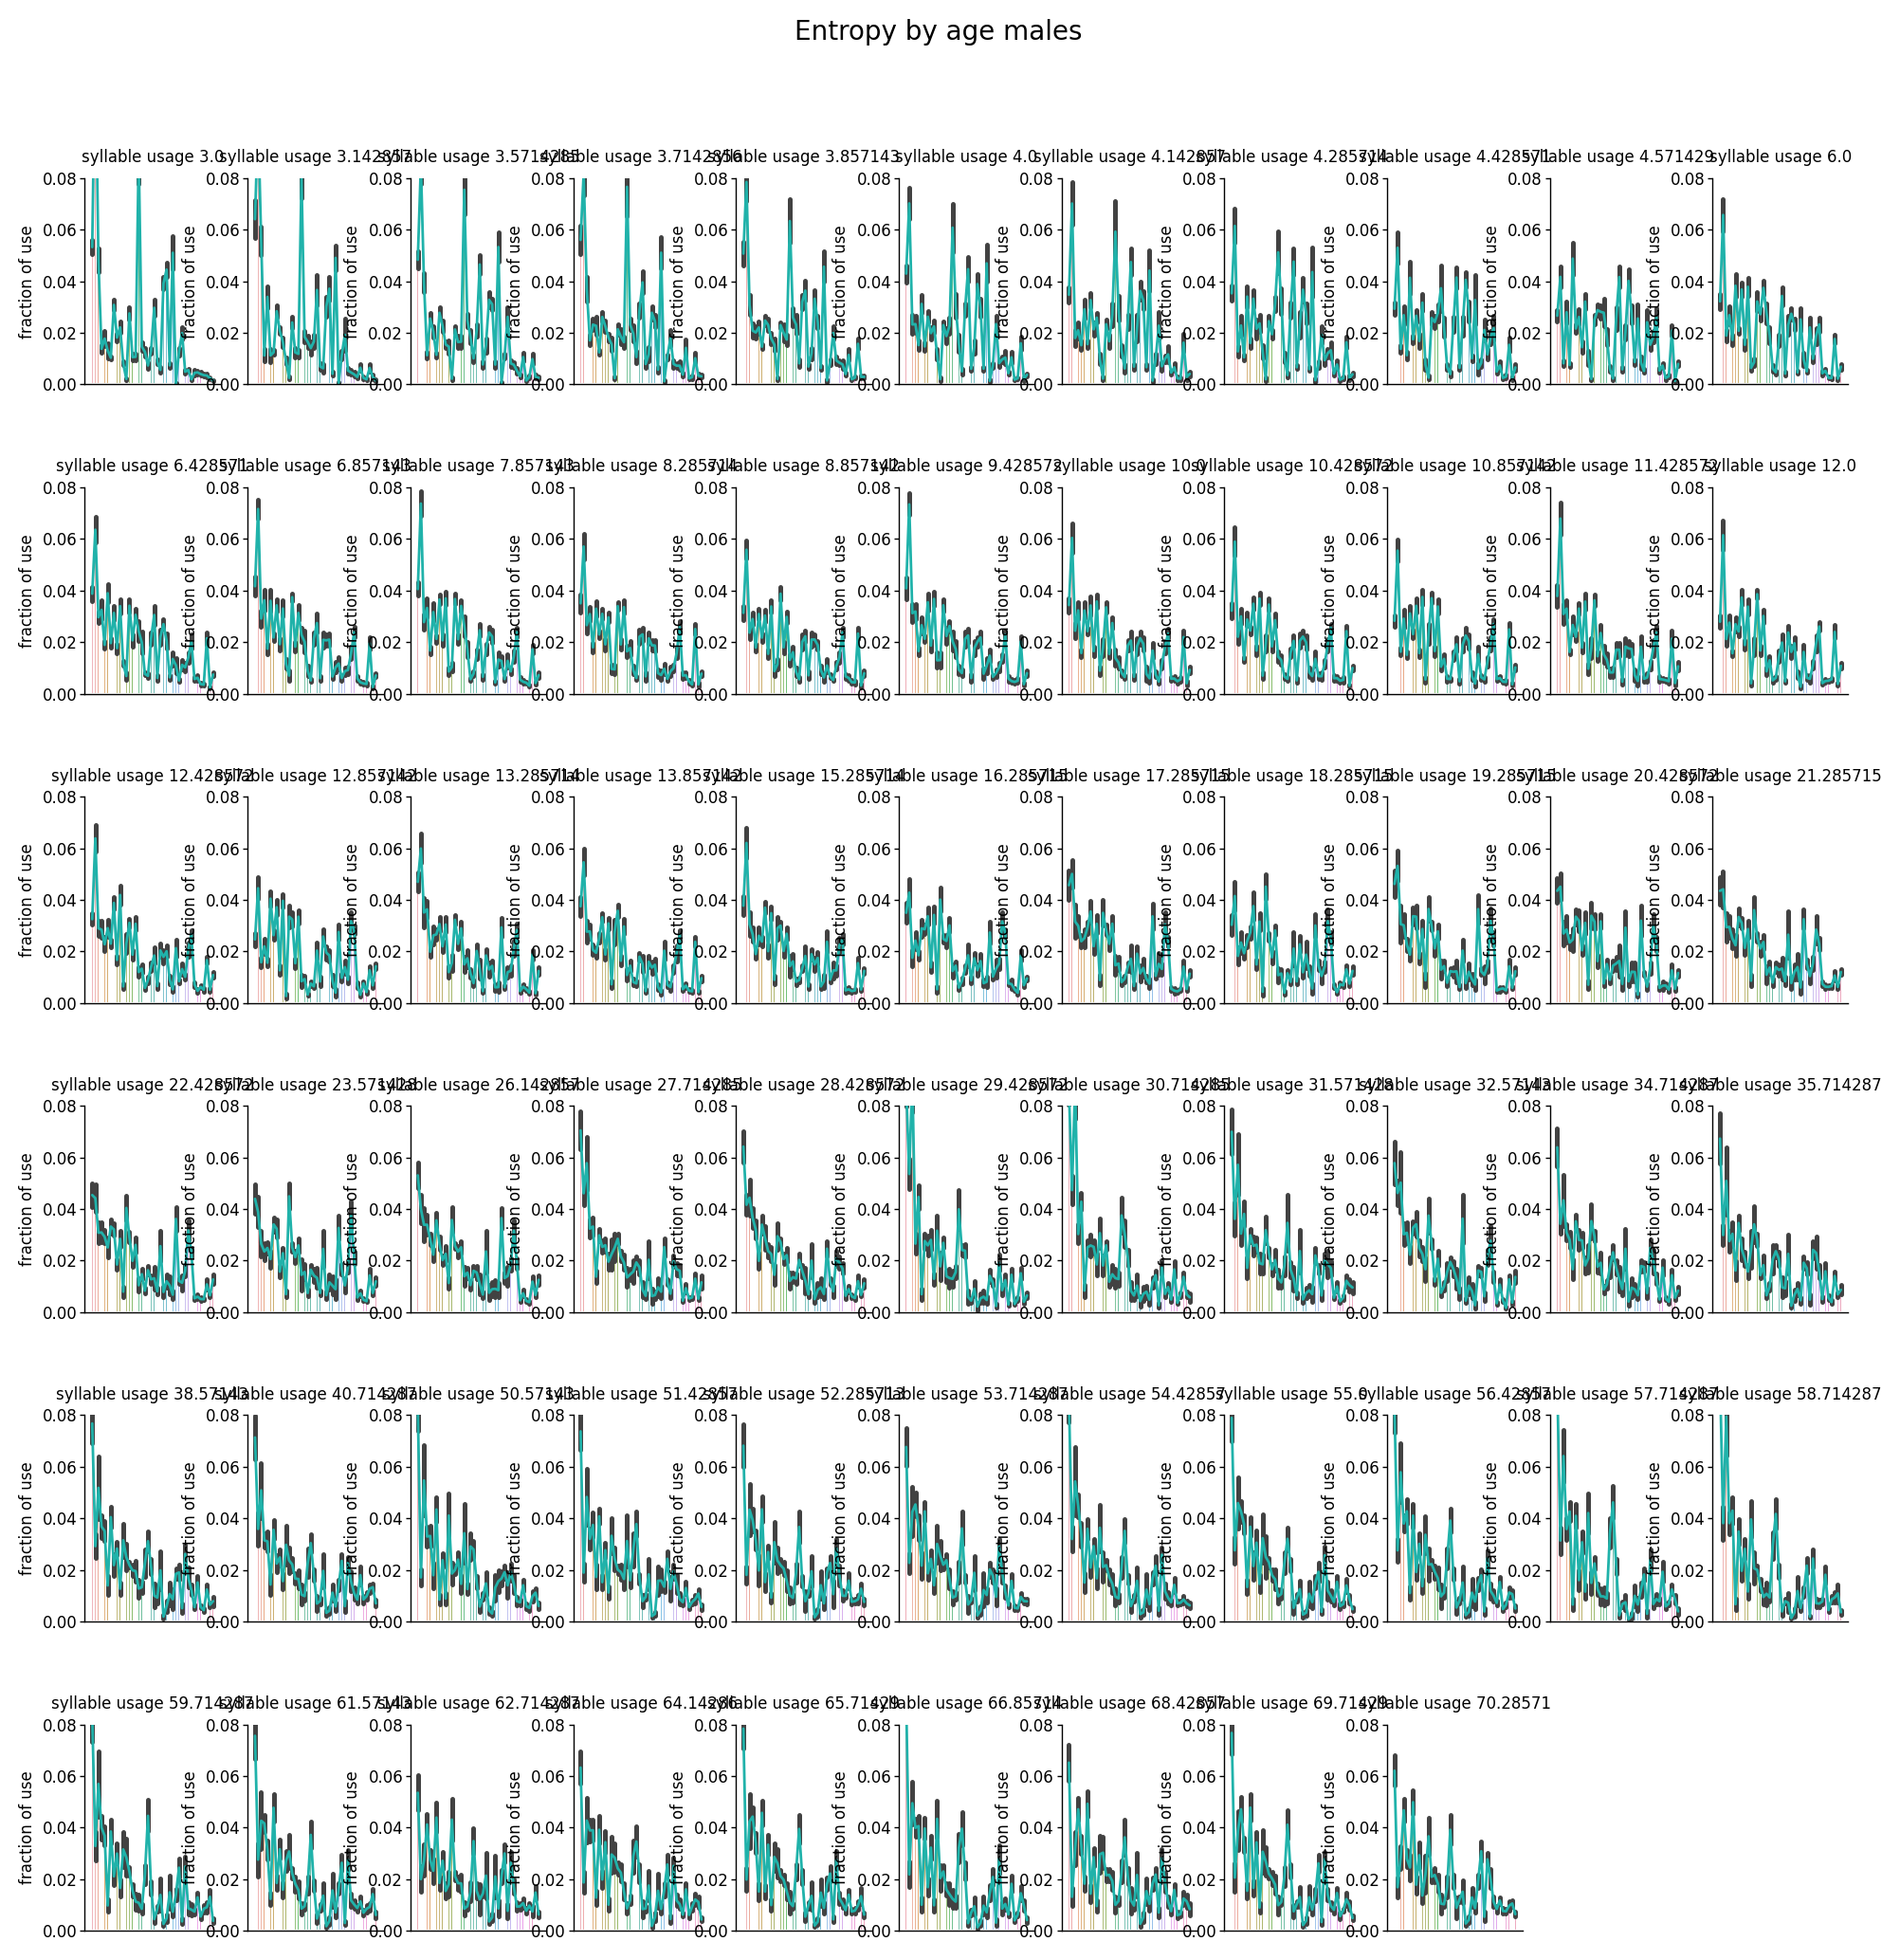

In [7]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age males", fontsize=10, y=0.95)
n=0
ages=[]
ent=[]

sigma = 2  
window_size = 3  
for age,_df in enumerate(m_data.groupby('age')):
    ages.extend(_df[1].index.get_level_values('age').to_numpy())
    data_temp = _df[1].to_numpy()
    #ent.extend(scipy.stats.entropy(data_temp, axis=1))
    arr = scipy.stats.entropy(data_temp, axis=1)
    #ent.extend(np.convolve(arr, np.ones(window_size)/window_size, mode='valid'))
    ent.extend(gaussian_filter1d(arr, sigma=sigma))
    ax = plt.subplot(6, 11, n + 1)
    sns.barplot(data_temp, errorbar='se',ax=ax)
    sns.lineplot(np.mean(data_temp, axis=0),ax=ax, color='#20B2AA')
    ax.set_title('syllable usage ' + str(_df[1].index.get_level_values('age').unique().to_numpy()[0]))
    ax.set_ylim(0,0.08)
    ax.set_xticks([])
    ax.set_ylabel('fraction of use')
    n=n+1
    sns.despine()

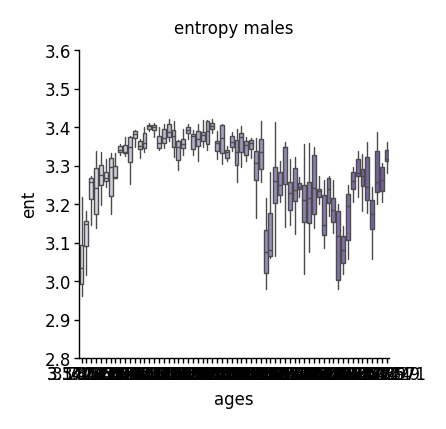

In [10]:
# plot entropy values
dfm=pd.DataFrame()
ages = [str(num) for num in ages]
dfm['ages']=ages
dfm['ent']=ent
dfm['sex'] = ['m'] * len(ages)
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
#sns.lineplot(data=df, x="ages", y="ent", estimator='mean', errorbar='se', c='black')
#sns.boxplot(data=dfm, x="ages", y="ent",showfliers=False, color='#20B2AA')
sns.boxplot(data=dfm, x="ages", y="ent",
             palette = pl, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
#sns.scatterplot(data=dfm, x="ages", y="ent",color='#20B2AA', alpha=0.50,s=10)
plt.setp(ax.collections, alpha=0.2)
plt.setp(ax.collections, edgecolor='none')
ax.set_title('entropy males')
ax.set_ylim(2.8,3.6)
sns.despine()

In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_entropy_boxplots.pdf')